# Primary analyses of our sequences

In [4]:
import os
import sys
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.crs as ccrs
%matplotlib inline

# Define the data directory
data_dir = '/home/jovyan/FunGut2/full-pipeline/data'

ModuleNotFoundError: No module named 'geopandas'

In [1]:
import os

In [11]:
!pwd

/home/jovyan/FunGut2/Nicola


### Checking out the reads

In [2]:
! qiime demux summarize \
  --i-data ./data/forward_reads/fungut_forward_reads.qza \
  --o-visualization ./data/forward_reads/fungut_forward_reads_summary.qzv

Saved Visualization to: ./data/forward_reads/fungut_forward_reads_summary.qzv


In [3]:
Visualization.load('./data/forward_reads/fungut_forward_reads_summary.qzv')

<visualization: Visualization uuid: 582a8e53-369c-47b2-b8be-0989ac41abfa>

#### As seen in the visualisation, the reads have very high quality up to a length of 150. Therefore we chose a truncation length of 150.

### Checking out the metadata

In [4]:
!qiime metadata tabulate \
  --m-input-file ./data/metadata/fungut_metadata.tsv \
  --o-visualization ./data/metadata/fungut_metadata.qzv

Saved Visualization to: ./data/metadata/fungut_metadata.qzv


In [5]:
Visualization.load('./data/metadata/fungut_metadata.qzv')

<visualization: Visualization uuid: e50404b6-baf8-43e0-a25d-05d016a918a1>

## Preprocessing the metadata

### Removing rows with NaN for Diseases

In [11]:
#read metadata
metadata = pd.read_csv("./data/metadata/fungut_metadata.tsv", sep="\t")

In [7]:
#count the rows that have column "ibd_sample" and "gluten_sample" = Not provided
filtered_rows = metadata[(metadata['ibd_sample'] == "Not provided") & (metadata['gluten_sample'] == "Not provided")]
print(len(filtered_rows), "samples have both response variables not provided")

#filter rows that have column "ibd_sample" and "gluten_sample" = Not provided
metadata = metadata[~((metadata['ibd_sample'] == "Not provided") & (metadata['gluten_sample'] == "Not provided"))]
metadata.describe()
print(len(filtered_rows), "samples have been removed")

4 samples have both response variables not provided
4 samples have been removed


### Removing rows with only NaN

In [8]:
# count the number of rows that have more than x columns not provided
for x in range(1, 6):
    count = metadata[metadata.eq("Not provided").sum(axis=1) >= x].shape[0]
    print(count, "samples have not provided", x, "columns")

62 samples have not provided 1 columns
10 samples have not provided 2 columns
5 samples have not provided 3 columns
2 samples have not provided 4 columns
1 samples have not provided 5 columns


We do not filter out any of these samples. the 5 missing columns in one sample is fine.

### Create new feature "Symptoms vs No-Symptoms"

In [9]:
metadata['gluten_sample'].unique()

array(['No',
       'I was diagnosed with gluten allergy (anti-gluten IgG), but not celiac disease',
       'I do not eat gluten because it makes me feel bad',
       'I was diagnosed with celiac disease', 'Not provided'],
      dtype=object)

In [10]:
# Define the categories to summarize as "symptoms"
no_symptoms = ['I do not have this condition']  

# Create a new column with a binary classification
metadata['ibd_symptoms'] = metadata['ibd_sample'].apply(
    lambda x: 'Not provided' if x == 'Not provided' else 
              ('no_symptoms' if x in no_symptoms else 'symptoms')
)

In [11]:
# Define the categories to summarize as "no_symptoms"
no_symptoms = ['No']  

# Create a new column with a binary classification
metadata['gluten_symptoms'] = metadata['gluten_sample'].apply(
    lambda x: 'Not provided' if x == 'Not provided' else 
              ('no_symptoms' if x in no_symptoms else 'symptoms')
)

### Add new feature "rural_urban"

In [12]:
# Create a boolean mask for rows with valid longitude and latitude values
valid_coords = (metadata['longitude_sample'] != "Not provided") & (metadata['latitude_sample'] != "Not provided")

# Initialize the 'is_urban' column with "Not provided"
metadata['is_urban'] = "Not provided"

# Process only rows with valid longitude and latitude
valid_metadata = metadata[valid_coords]

# Convert valid latitude and longitude columns to a GeoDataFrame
gdf = gpd.GeoDataFrame(valid_metadata, 
                       geometry=gpd.points_from_xy(valid_metadata['longitude_sample'].astype(float), 
                                                   valid_metadata['latitude_sample'].astype(float)), 
                       crs="EPSG:4326")

# Load the shapefile for urban areas
urban_areas = gpd.read_file('./data/urban_areas/ne_10m_urban_areas.shp')

# Perform the spatial join for valid rows
gdf['is_urban'] = gpd.sjoin(gdf, urban_areas, predicate='within', how='left').index_right.notnull()

# Update the 'is_urban' column in the original metadata DataFrame
metadata.loc[valid_coords, 'is_urban'] = gdf['is_urban'].astype(bool)

### Save processed metadata as tsv file

In [13]:
metadata.to_csv('./data/metadata/fungut_metadata_processed.tsv', sep='\t', index=False)

### Filtering the forward reads like we did the metadata

In [14]:
!qiime demux filter-samples \
    --i-demux ./data/forward_reads/fungut_forward_reads.qza \
    --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
    --o-filtered-demux ./data/forward_reads/filtered_fungut_forward_reads.qza

Saved SampleData[SequencesWithQuality] to: ./data/forward_reads/filtered_fungut_forward_reads.qza


### Checking out the filtered forward reads

In [16]:
! qiime demux summarize \
  --i-data ./data/forward_reads/filtered_fungut_forward_reads.qza \
  --o-visualization ./data/forward_reads/filtered_fungut_forward_reads_summary.qzv

Saved Visualization to: ./data/forward_reads/filtered_fungut_forward_reads_summary.qzv


In [17]:
Visualization.load('./data/forward_reads/filtered_fungut_forward_reads_summary.qzv')

<visualization: Visualization uuid: 9598bdd3-8737-43ea-9c34-152d7c2c9f59>

### Denoising with dada2
We decided not to truncate or trimm because the quality scores remained consistently high (all 25th percentile scores ≥ 30) across the entire read length. This ensures that we retain the maximum amount of sequence information for downstream analyses while avoiding unnecessary data loss.

In [20]:
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs ./data/forward_reads/filtered_fungut_forward_reads.qza \
  --p-trim-left 0 \
  --p-trunc-len 0 \
  --o-representative-sequences ./data/rep-seqs.qza \
  --o-table ./data/feature-table.qza \
  --o-denoising-stats ./data/denoising-stats.qza

Saved FeatureTable[Frequency] to: ./data/feature-table.qza
Saved FeatureData[Sequence] to: ./data/rep-seqs.qza
Saved SampleData[DADA2Stats] to: ./data/denoising-stats.qza


#### Check out the feature table

In [21]:
!qiime feature-table summarize \
  --i-table ./data/feature-table.qza \
  --o-visualization ./data/feature-table-summary.qzv

Saved Visualization to: ./data/feature-table-summary.qzv


In [ ]:
Visualization.load('./data/feature-table-summary.qzv')

### Classification
This step was executed on Euler, as we ran into the problem of not having sufficient memory on JupyterHub
See our bash script we ran on Euler in './scripts/'

For classification we used the UNITE pretrained classifier from:

https://github.com/colinbrislawn/unite-train/releases

Classification was performed with `unite_ver10_dynamic_s_all_04.04.2024-Q2-2024.5.qza`, since resources were not an issue when performing the classification on `Euler`.

In [ ]:
'''
!qiime feature-classifier classify-sklearn \
  --i-classifier ./data/taxonomy_classification/unite_ver10_dynamic_s_all_04.04.2024-Q2-2024.5.qza \
  --i-reads ./data/rep-seqs.qza \
  --p-reads-per-batch 1000 \
  --o-classification ./taxonomy_unite_dynamic_s_all.qza
'''

In [23]:
# tabulation of the taxonomy classification
!qiime metadata tabulate \
  --m-input-file ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
  --o-visualization ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv

Saved Visualization to: ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv


Looking through the classification, we observed 30 `Unassigned` and 2 `Eukaryota` classifications which we will filter out in the next step.

In [24]:
Visualization.load('./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv')

<visualization: Visualization uuid: ba236441-86fa-4cc5-944c-0b163bc9abfe>

#### Create the taxonomy bar plot

In [25]:
!qiime taxa barplot \
  --i-table ./data/feature-table.qza \
  --i-taxonomy ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --o-visualization ./data/taxa-bar-plots.qzv

Saved Visualization to: ./data/taxa-bar-plots.qzv


We here further observe classifications belonging to different kingdoms than `k__Fungi`, which we will also filter out in the next step.

In [4]:
Visualization.load('./data/taxa-bar-plots.qzv')

<visualization: Visualization uuid: a6b15a2c-0ca2-466a-997c-5d9dd10cfdb9>

#### Filtering the feature table to exclude eukaryotes
We observed that we have contamination in our samples, so we filtered out those assigned `Eukaryota` and `Unassigned`.



In [28]:
!qiime taxa filter-table \
  --i-table ./data/feature-table.qza \
  --i-taxonomy ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
  --p-include k__Fungi \
  --o-filtered-table ./data/filtered-feature-table.qza


Saved FeatureTable[Frequency] to: ./data/filtered-feature-table.qza


We now regenerate the taxonomy barplot to ensure we only have k__Fungi classifications.

In [29]:
!qiime taxa barplot \
  --i-table ./data/filtered-feature-table.qza \
  --i-taxonomy ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --o-visualization ./data/filtered-taxa-bar-plots.qzv

Saved Visualization to: ./data/filtered-taxa-bar-plots.qzv


In [5]:
Visualization.load('./data/filtered-taxa-bar-plots.qzv')

<visualization: Visualization uuid: 6e31c62c-0d26-496b-9bfc-a3d87ba46339>

In [31]:
!qiime feature-table summarize\
    --i-table ./data/filtered-feature-table.qza \
    --o-visualization ./data/filtered-feature-table_summary.qzv

Saved Visualization to: ./data/filtered-feature-table_summary.qzv


In [6]:
Visualization.load('./data/filtered-feature-table_summary.qzv')

<visualization: Visualization uuid: 710186d0-4ddc-4483-928a-8c881daf4c2b>

### Creating a phylogenetic tree

#### First we align our sequences

In [33]:
! qiime alignment mafft \
    --i-sequences ./data/rep-seqs.qza \
    --o-alignment ./data/aligned-rep-seqs.qza

Saved FeatureData[AlignedSequence] to: ./data/aligned-rep-seqs.qza


#### Alignment masking

In [34]:
! qiime alignment mask \
    --i-alignment ./data/aligned-rep-seqs.qza \
    --o-masked-alignment ./data/masked-aligned-rep-seqs.qza

Saved FeatureData[AlignedSequence] to: ./data/masked-aligned-rep-seqs.qza


#### Tree construction

In [35]:
! qiime phylogeny fasttree \
    --i-alignment ./data/masked-aligned-rep-seqs.qza \
    --o-tree ./data/phylogeny/fast-tree.qza

! qiime phylogeny midpoint-root \
    --i-tree ./data/phylogeny/fast-tree.qza \
    --o-rooted-tree ./data/phylogeny/fast-tree-rooted.qza

Saved Phylogeny[Unrooted] to: ./data/fast-tree.qza
Saved Phylogeny[Rooted] to: ./data/fast-tree-rooted.qza


#### Unable to create tree visualization on Jupyter

Saddly we weren't able to install the qiime2 plugin empress to create the tree visualization, which is why we ran this step on `Euler`.
The bash file we executed on Euler can be found in `./scripts/tree_visualization.sh`.

In [36]:
Visualization.load('./data/phylogeny/fast-tree-rooted.qzv')

<visualization: Visualization uuid: 65627d58-5d93-45f6-b058-165ddd931101>

#### Alpha rarefaction

In [37]:
!qiime diversity alpha-rarefaction \
  --i-table ./data/filtered-feature-table.qza \
  --i-phylogeny ./data/phylogeny/fast-tree-rooted.qza \
  --p-max-depth  30000 \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --o-visualization ./data/alpha_diversity/alpha-rarefaction.qzv


Saved Visualization to: ./data/alpha_diversity/alpha-rarefaction.qzv


In [38]:
Visualization.load('./data/alpha_diversity/alpha-rarefaction.qzv')

<visualization: Visualization uuid: 8f71a580-4c35-49c0-932b-d87061036f49>

#### Compute metrics
We chose a sampling depth of 5000, as the shannon metric plateaus shortly before it  


In [40]:
! qiime diversity core-metrics-phylogenetic \
  --i-table ./data/filtered-feature-table.qza \
  --i-phylogeny ./data/phylogeny/fast-tree-rooted.qza \
  --m-metadata-file ./data/metadata/fungut_metadata_processed.tsv \
  --p-sampling-depth 5000 \
  --output-dir ./data/alpha_diversity/core-metrics-results

Saved FeatureTable[Frequency] to: ./data/alpha_diversity/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ./data/alpha_diversity/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: ./data/alpha_diversity/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./data/alpha_diversity/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: ./data/alpha_diversity/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ./data/alpha_diversity/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ./data/alpha_diversity/core-metrics-results/unweighted_un

### Check out the core metrics results visualizations
For easier inspection of the core metrics results we implemented a ipywidget for easier switching between visualizations.

In [7]:
sys.path.append(os.path.join(os.getcwd(), 'scripts'))
from qzv_selector import display_qzv_selector
display_qzv_selector('./data/alpha_diversity/core-metrics-results')

Dropdown(description='Select .qzv file:', options=('bray_curtis_emperor.qzv', 'jaccard_emperor.qzv', 'weighted…

Output()

In [42]:
# test_import.py
from qzv_selector import create_category_selector

category_dropdown = create_category_selector()


/opt/conda/lib/python3.9/site-packages/q2_types/sample_data/_transformer.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


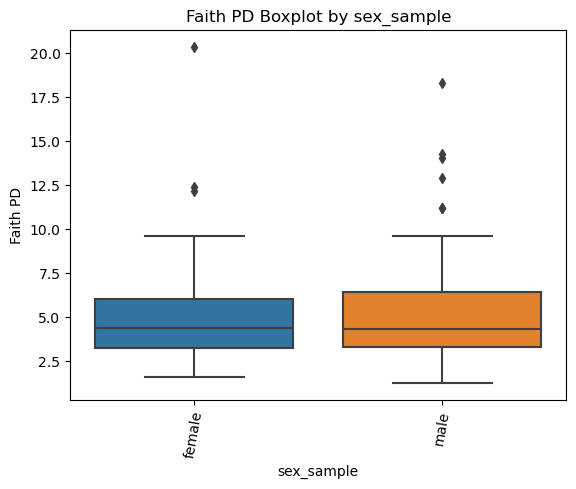

In [44]:
types = category_dropdown.value

div = q2.Artifact.load('./data/alpha_diversity/core-metrics-results/faith_pd_vector.qza').view(pd.Series)
md = pd.read_csv('./data/metadata/fungut_metadata_processed.tsv', sep='\t', index_col=0)[f'{types}_sample']
# Concatenate the series that we provided
dd = pd.concat([div, md], axis=1, join='inner')

# make a boxplot with Faith PD on the y-axis and the selected 'type' on the x-axis (hint: look at the "by" parameter)
sns.boxplot(x=f'{types}_sample', y = dd.columns[0], data = dd)
plt.xlabel(f'{types}_sample')
plt.xticks(rotation = 80)
plt.ylabel('Faith PD')
plt.title(f'Faith PD Boxplot by {types}_sample')
plt.show()

## NEW
### Beta_diversity

In [4]:
! pwd

/home/jovyan/FunGut2/Nicola


In [8]:
from skbio import OrdinationResults
from qiime2 import Visualization
from seaborn import scatterplot

In [9]:
pcs = q2.Artifact.load(os.path.join('../full-pipeline/data/alpha_diversity/core-metrics-results/unweighted_unifrac_pcoa_results.qza'))
pcs = pcs.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
pcs_data = pcs.samples.iloc[:,:3]
# rename the columns for clarity
pcs_data.columns = ['Axis 1', 'Axis 2', 'Axis 3']

In [17]:
metadata = pd.read_csv("../full-pipeline/data/metadata/fungut_metadata_processed.tsv", 
                       sep="\t", 
                       index_col=0
    )

In [18]:
pcs_data_with_md = merged_df = pd.merge(metadata, pcs_data, left_index=True, right_index=True)
pcs_data_with_md.head()

,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample,ibd_symptoms,gluten_symptoms,is_urban,Axis 1,Axis 2,Axis 3
ERR5327198,USA,TN,36.1,-86.8,female,67,152,41,17.75,Omnivore,I do not have this condition,No,no_symptoms,no_symptoms,True,0.207250,-0.018048,-0.048870
ERR5327199,USA,DC,38.9,-77.1,male,55.0,182.0,79.0,23.73,Omnivore,I do not have this condition,I was diagnosed with gluten allergy (anti-glut...,no_symptoms,symptoms,True,-0.170252,-0.312261,-0.084945
ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,I do not have this condition,I do not eat gluten because it makes me feel bad,no_symptoms,symptoms,True,-0.148098,0.055881,-0.014650
ERR5327282,United Kingdom,Not provided,51.6,-0.2,female,26.0,166.0,60.0,21.77,Omnivore,I do not have this condition,No,no_symptoms,no_symptoms,True,-0.022064,0.085922,0.224176
ERR5327284,United Kingdom,Not provided,51.5,-0.2,female,25.0,173.0,59.0,20.01,Vegetarian but eat seafood,I do not have this condition,No,no_symptoms,no_symptoms,True,0.269120,0.007269,0.022519


<Axes: xlabel='Axis 1', ylabel='Axis 2'>

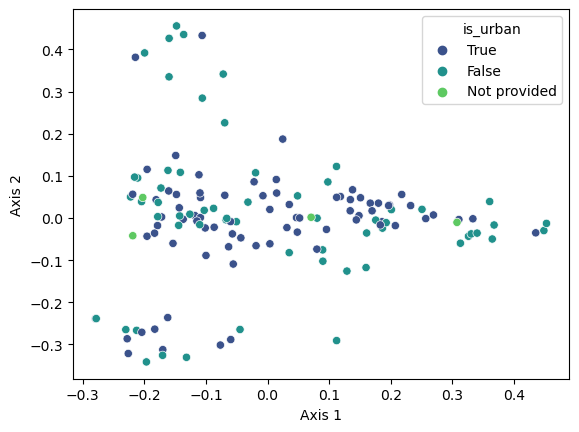

In [20]:
scatterplot(data=pcs_data_with_md,
            x='Axis 1',
            y='Axis 2',
            hue='is_urban',
            palette='viridis')

## Differential abbundance

In [21]:
from scipy.stats import shapiro, kruskal, f_oneway

In [26]:
data = q2.Artifact.load(f'{data_dir}/feature-table.qza').view(pd.DataFrame)

In [27]:
data.head()

,beb8f130fd78d92d09b9aa1e37fec750,1a15e1ac583395ebef75c14409e87352,2cbfc59f930219d7c49d96415c2682f1,bdc03ca13c072d3ca6db327ed382cc7f,6e3a38e86a2e4f4fd6d507b533c8d30c,28601b0842b9b4c2914d17bc4a54ab03,e8cdb05dc6b8742138c410b76d2f9057,940e166f60beb613ec316fd209b9adb8,c84004c0020de7d6ff5bde95677e8688,f99a453bb41ad922be6277dbcfd21424,...,21f510f57ea3f8f04ac8bfb3f34ae2e4,583ac103f42e2cb9d5bba11e5d96ec60,2ecbe7c59774e051b1b21da8219776d1,3390ddf8f6746b87b58f1aaedb7df952,98f75c025283be256713485701c2844a,15c85517203d7043a89c8cb87ba7a217,8da95e9a86a7c3ec7ec3cbf234a1c7fc,81a4ccb828d7eb015da463cd68409532,5626797b16f53ea2bcc4748e6e671dc4,103a02c3b0481290e6f9827d32ee93cc
ERR5327198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR5327199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR5327266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR5327282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR5327284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


beb8f130fd78d92d09b9aa1e37fec750    2.0
1a15e1ac583395ebef75c14409e87352    9.0
2cbfc59f930219d7c49d96415c2682f1    2.0
dtype: float64


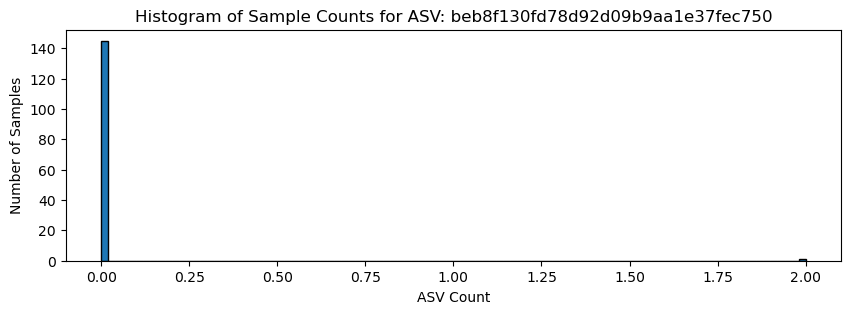

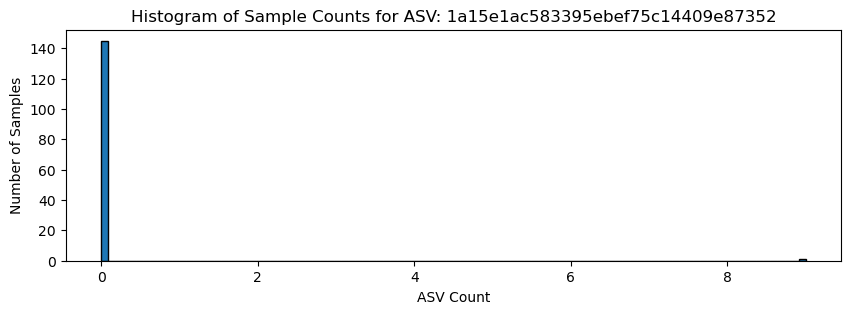

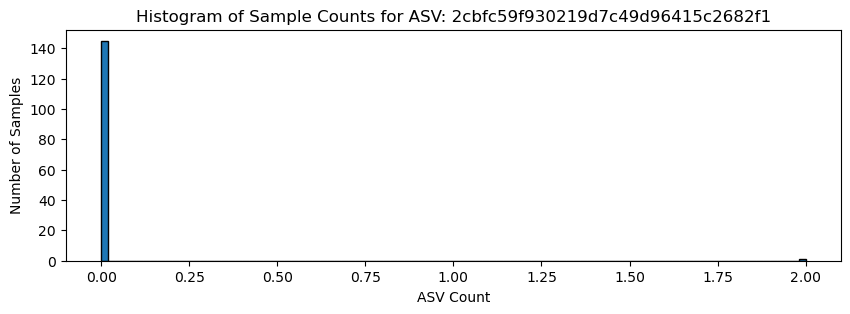

In [28]:
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum()[:3].index]
print(top_three.sum())

for asv in top_three.columns:
    plt.figure(figsize=(10, 3))
    plt.hist(top_three[asv], bins=100, edgecolor='black')
    plt.title(f"Histogram of Sample Counts for ASV: {asv}")
    plt.xlabel("ASV Count")
    plt.ylabel("Number of Samples")
    plt.show()
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.


In [29]:
n = 15

# draw n ASVs out of the original DataFrame
data_samp = data.sample(n=n, axis=1, random_state=234)

# create a new DataFrame with three columns (sample, ASV, abundance)
col_names = {'level_0': 'sample', 'level_1': 'asv', 0: 'count'}
data_plot = data_samp.stack().reset_index().rename(columns=col_names)

# make sure the shape is correct (no. of rows should be equal to the size of our random 
# sample multiplied by number of samples)
assert data_plot.shape[0] == n * data_samp.shape[0], 'The new DataFrame has an incorrect no. of rows.'

In [30]:
data_plot.head()

,sample,asv,count
0,ERR5327198,f39c0d3fbd894b011a83ef471fa88201,0.0
1,ERR5327198,53169f3a2e83ee3517a41fcccf9bcd1b,0.0
2,ERR5327198,18fe8be52b3c21f154e616007372e2ae,0.0
3,ERR5327198,42542607a64e7d3a94e3ebea7095b953,0.0
4,ERR5327198,bd28d89dcf8bdd668b5bea2f7cecce85,0.0


# ANCOMBC
filter

In [10]:
! qiime feature-table filter-features \
    --i-table $data_dir/filtered-feature-table.qza \
    --p-min-frequency 25 \
    --p-min-samples 4 \
    --o-filtered-table ./table_abund.qza

Usage: qiime feature-table filter-features [OPTIONS]

  Filter features from table based on frequency and/or metadata. Any samples
  with a frequency of zero after feature filtering will also be removed. See
  the filtering tutorial on https://docs.qiime2.org for additional details.

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency]
                       The feature table from which features should be
                       filtered.                                    [required]
Parameters:
  --p-min-frequency INTEGER
                       The minimum total frequency that a feature must have
                       to be retained.                            [default: 0]
  --p-max-frequency INTEGER
                       The maximum total frequency that a feature can have to
                       be retained. If no value is provided this will default
                       to infinity (i.e., no maximum frequency filter will be
                       applied).                       

In [7]:
! qiime taxa collapse \
    --i-table ./table_abund.qza \
    --i-taxonomy $data_dir/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
    --p-level 6 \
    --o-collapsed-table ./table_abund_l6.qza

Usage: qiime taxa collapse [OPTIONS]

  Collapse groups of features that have the same taxonomic assignment through
  the specified level. The frequencies of all features will be summed when
  they are collapsed.

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency]
                         Feature table to be collapsed.             [required]
  --i-taxonomy ARTIFACT FeatureData[Taxonomy]
                         Taxonomic annotations for features in the provided
                         feature table. All features in the feature table must
                         have a corresponding taxonomic annotation. Taxonomic
                         annotations that are not present in the feature table
                         will be ignored.                           [required]
Parameters:
  --p-level INTEGER      The taxonomic level at which the features should be
                         collapsed. All ouput features will have exactly this
                         many levels of taxonomic 

### urban_rural comparison

In [8]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table ./table_abund_l6.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-formula is_urban \
    --o-differentials ./ancombc_urban_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data ./ancombc_urban_differentials.qza \
    --o-visualization ./ancombc_urban_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data ./ancombc_urban_differentials.qza \
    --o-visualization ./ancombc_urban_results.qzv

There was an issue with loading the file /metadata/fungut_metadata_processed.tsv as metadata:

  Metadata file path doesn't exist, or the path points to something other than a file. Please check that the path exists, has read permissions, and points to a regular file (not a directory): /metadata/fungut_metadata_processed.tsv

  There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

  Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2024.5/tutorials/metadata/

Saved Visualization to: ./ancombc_urban_da_barplot.qzv
Saved Visualization to: ./ancombc_urban_results.qzv


In [5]:
Visualization.load("./ancombc_urban_da_barplot.qzv")

<visualization: Visualization uuid: 00209e7b-b2bb-4421-a3ec-c50de0315c6e>

### IBD comparison

In [39]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table ./table_abund_l6.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-formula ibd_symptoms \
    --o-differentials ./ancombc_ibd_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data ./ancombc_ibd_differentials.qza \
    --o-visualization ./ancombc_ibd_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data ./ancombc_ibd_differentials.qza \
    --o-visualization ./ancombc_ibd_results.qzv

Saved FeatureData[DifferentialAbundance] to: ./ancombc_ibd_differentials.qza
Saved Visualization to: ./ancombc_ibd_da_barplot.qzv
Saved Visualization to: ./ancombc_ibd_results.qzv


In [41]:
Visualization.load("./ancombc_ibd_da_barplot.qzv")

<visualization: Visualization uuid: f0024657-60c2-4817-93d0-42ace4501682>

### Gluten comparison

In [42]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table ./table_abund_l6.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-formula gluten_symptoms \
    --o-differentials ./ancombc_gluten_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data ./ancombc_gluten_differentials.qza \
    --o-visualization ./ancombc_gluten_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data ./ancombc_gluten_differentials.qza \
    --o-visualization ./ancombc_gluten_results.qzv

Saved FeatureData[DifferentialAbundance] to: ./ancombc_gluten_differentials.qza
Saved Visualization to: ./ancombc_gluten_da_barplot.qzv
Saved Visualization to: ./ancombc_gluten_results.qzv


In [43]:
Visualization.load("./ancombc_gluten_da_barplot.qzv")

<visualization: Visualization uuid: 0dace789-7ee1-4f0e-a7eb-c3e233aef242>